<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/TutorialTaskImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Creating Tasks

## Pre-requisite

Before we start, we need to install EvoJAX and import some libraries.  
**Note** In our [paper](https://arxiv.org/abs/2202.05008), we ran the experiments on NVIDIA V100 GPU(s). Your results can be different from ours.

In [1]:
from IPython.display import clear_output, Image

!pip install evojax
!pip install torchvision  # We use torchvision.datasets.MNIST in this tutorial.

clear_output()

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp

from evojax.task.cartpole import CartPoleSwingUp
from evojax.policy.mlp import MLPPolicy
from evojax.algo import PGPE
from evojax import Trainer
from evojax.util import create_logger

In [3]:
# Let's create a directory to save logs and models.
log_dir = './log'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('Welcome to the tutorial on Task creation!')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

EvoJAX: 2022-02-12 05:53:28,121 [INFO] Welcome to the tutorial on Task creation!
absl: 2022-02-12 05:53:28,133 [INFO] Starting the local TPU driver.
absl: 2022-02-12 05:53:28,135 [INFO] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
absl: 2022-02-12 05:53:28,519 [INFO] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
EvoJAX: 2022-02-12 05:53:28,520 [INFO] Jax backend: [GpuDevice(id=0, process_index=0)]


Tesla V100-SXM2-16GB


## Introduction

EvoJAX has three major components: the *task*, the *policy network* and the *neuroevolution algorithm*. Once these components are implemented and instantiated, we can use a trainer to start the training process. The following code snippet provides an example of how we use EvoJAX.

In [4]:
seed = 42  # Wish me luck!

# We use the classic cart-pole swing up as our tasks, see
# https://github.com/google/evojax/tree/main/evojax/task for more example tasks.
# The test flag provides the opportunity for a user to
# 1. Return different signals as rewards. For example, in our MNIST example,
#    we use negative cross-entropy loss as the reward in training tasks, and the
#    classification accuracy as the reward in test tasks.
# 2. Perform reward shaping. It is common for RL practitioners to modify the
#    rewards during training so that the agent learns more efficiently. But this
#    modification should not be allowed in tests for fair evaluations.
hard = False
train_task = CartPoleSwingUp(harder=hard, test=False)
test_task = CartPoleSwingUp(harder=hard, test=True)

# We use a feedforward network as our policy.
# By default, MLPPolicy uses "tanh" as its activation function for the output.
policy = MLPPolicy(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[64, 64],
    output_dim=train_task.act_shape[0],
    logger=logger,
)

# We use PGPE as our evolution algorithm.
# If you want to know more about the algorithm, please take a look at the paper:
# https://people.idsia.ch/~juergen/nn2010.pdf 
solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

# Now that we have all the three components instantiated, we can create a
# trainer and start the training process.
trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=600,
    log_interval=100,
    test_interval=200,
    n_repeats=5,
    n_evaluations=128,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-02-12 05:53:31,223 [INFO] MLPPolicy.num_params = 4609
EvoJAX: 2022-02-12 05:53:31,381 [INFO] Start to train for 600 iterations.
EvoJAX: 2022-02-12 05:53:42,936 [INFO] Iter=100, size=64, max=717.4396, avg=632.6160, min=475.3617, std=51.3240
EvoJAX: 2022-02-12 05:53:51,773 [INFO] Iter=200, size=64, max=838.2386, avg=751.0416, min=592.3156, std=46.3648
EvoJAX: 2022-02-12 05:53:53,555 [INFO] [TEST] Iter=200, #tests=128, max=880.2914 avg=834.9127, min=763.1976, std=40.8967
EvoJAX: 2022-02-12 05:54:02,542 [INFO] Iter=300, size=64, max=917.9876, avg=857.5809, min=48.2173, std=133.0970
EvoJAX: 2022-02-12 05:54:11,668 [INFO] Iter=400, size=64, max=917.4292, avg=900.6838, min=544.6534, std=53.2497
EvoJAX: 2022-02-12 05:54:11,770 [INFO] [TEST] Iter=400, #tests=128, max=927.4318 avg=918.8890, min=909.4037, std=3.2266
EvoJAX: 2022-02-12 05:54:20,773 [INFO] Iter=500, size=64, max=922.2775, avg=868.8109, min=227.3976, std=147.4509
EvoJAX: 2022-02-12 05:54:29,884 [INFO] [TEST] Iter=600, #

reward=[934.1182]


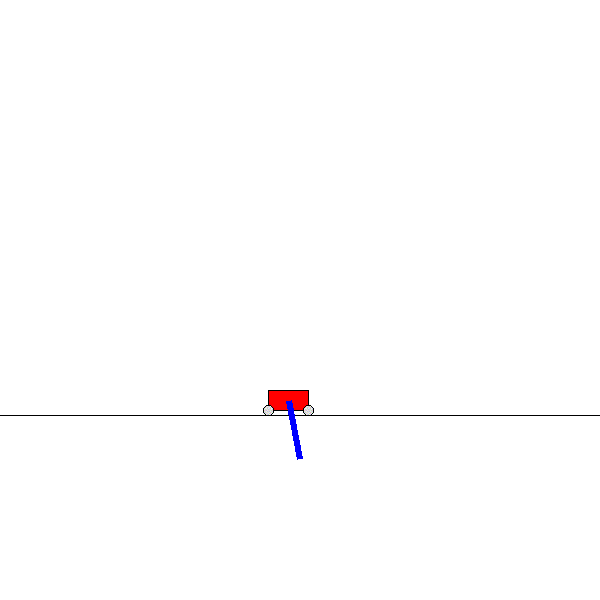

In [5]:
# Let's visualize the learned policy.

def render(task, algo, policy):
    """Render the learned policy."""

    task_reset_fn = jax.jit(test_task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(test_task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [CartPoleSwingUp.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, d = step_fn(task_s, act)
        step += 1
        reward = reward + r
        done = bool(d[0])
        if step % 3 == 0:
            images.append(CartPoleSwingUp.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


imgs = render(test_task, solver, policy)
gif_file = os.path.join(log_dir, 'cartpole.gif')
imgs[0].save(
    gif_file, save_all=True, append_images=imgs[1:], duration=40, loop=0)
Image(open(gif_file,'rb').read())

Including the three major components, EvoJAX implements the entire training pipeline in JAX. In the first release, we have created several [demo tasks](https://github.com/google/evojax/tree/main/evojax/task) to showcase EvoJAX's capacity. And we encourage the users to bring their own tasks. To this end, we will walk you through the process of creating EvoJAX tasks in this tutorial.

To contribute a task implementation to EvoJAX, all you need to do is to implement the `VectorizedTask` interface.  
The interface is defined as the following and you can see the related Python file [here](https://github.com/google/evojax/blob/main/evojax/task/base.py):
```python
class TaskState(ABC):
    """A template of the task state."""
    obs: jnp.ndarray


class VectorizedTask(ABC):
    """Interface for all the EvoJAX tasks."""

    max_steps: int
    obs_shape: Tuple
    act_shape: Tuple
    test: bool
    multi_agent_training: bool = False

    @abstractmethod
    def reset(self, key: jnp.array) -> TaskState:
        """This resets the vectorized task.
        Args:
            key - A jax random key.
        Returns:
            TaskState. Initial task state.
        """
        raise NotImplementedError()

    @abstractmethod
    def step(self,
             state: TaskState,
             action: jnp.ndarray) -> Tuple[TaskState, jnp.ndarray, jnp.ndarray]:
        """This steps once the simulation.
        Args:
            state - System internal states of shape (num_tasks, *).
            action - Vectorized actions of shape (num_tasks, action_size).
        Returns:
            TaskState. Task states.
            jnp.ndarray. Reward.
            jnp.ndarray. Task termination flag: 1 for done, 0 otherwise.
        """
        raise NotImplementedError()
```

## MNIST classification

While one would obviously use gradient descent for MNIST in practice, the point is to show that neuroevolution can also solve them to some degree of accuracy within a short amount of time, which will be useful when these models are adapted within a more complicated task where gradient-based approaches may not work.

The following code snippet shows how we wrap the dataset and treat it as a one-step `VectorizedTask`.

In [6]:
from torchvision import datasets
from flax.struct import dataclass
from evojax.task.base import TaskState
from evojax.task.base import VectorizedTask


# This state contains the information we wish to carry over to the next step.
# The state will be used in `VectorizedTask.step` method.
# In supervised learning tasks, we want to store the data and the labels so that
# we can calculate the loss or the accuracy and use that as the reward signal.
@dataclass
class State(TaskState):
    obs: jnp.ndarray
    labels: jnp.ndarray


def sample_batch(key, data, labels, batch_size):
    ix = jax.random.choice(
        key=key, a=data.shape[0], shape=(batch_size,), replace=False)
    return (jnp.take(data, indices=ix, axis=0),
            jnp.take(labels, indices=ix, axis=0))


def loss(prediction, target):
    target = jax.nn.one_hot(target, 10)
    return -jnp.mean(jnp.sum(prediction * target, axis=1))


def accuracy(prediction, target):
    predicted_class = jnp.argmax(prediction, axis=1)
    return jnp.mean(predicted_class == target)


class MNIST(VectorizedTask):
    """MNIST classification task.

    We model the classification as an one-step task, i.e.,
    `MNIST.reset` returns a batch of data to the agent, the agent outputs
    predictions, `MNIST.step` returns the reward (loss or accuracy) and
    terminates the rollout.
    """

    def __init__(self, batch_size, test):

        self.max_steps = 1

        # These are similar to OpenAI Gym environment's
        # observation_space and action_space.
        # They are helpful for initializing the policy networks.
        self.obs_shape = tuple([28, 28, 1])
        self.act_shape = tuple([10, ])

        # We download the dataset and normalize the value.
        dataset = datasets.MNIST('./data', train=not test, download=True)
        data = np.expand_dims(dataset.data.numpy() / 255., axis=-1)
        labels = dataset.targets.numpy()

        def reset_fn(key):
            if test:
                # In the test mode, we want to test on the entire test set.
                batch_data, batch_labels = data, labels
            else:
                # In the training mode, we only sample a batch of training data.
                batch_data, batch_labels = sample_batch(
                    key, data, labels, batch_size)
            return State(obs=batch_data, labels=batch_labels)
        
        # We use jax.vmap for auto-vectorization.
        self._reset_fn = jax.jit(jax.vmap(reset_fn))

        def step_fn(state, action):
            if test:
                # In the test mode, we report the classification accuracy.
                reward = accuracy(action, state.labels)
            else:
                # In the training mode, we return the negative loss as the
                # reward signal. It is legitimate to return accuracy as the
                # reward signal in training too, but we find the performance is
                # not as good as when we use the negative loss.
                reward = -loss(action, state.labels)
            # This is an one-step task, so that last return value (the `done`
            # flag) is one.
            return state, reward, jnp.ones(())

        # We use jax.vmap for auto-vectorization.
        self._step_fn = jax.jit(jax.vmap(step_fn))

    def reset(self, key):
        return self._reset_fn(key)

    def step(self, state, action):
        return self._step_fn(state, action)

In [7]:
# Okay, let's test out the task with a ConvNet policy.

from evojax.policy.convnet import ConvNetPolicy


batch_size = 1024
train_task = MNIST(batch_size=batch_size, test=False)
test_task = MNIST(batch_size=batch_size, test=True)

policy = ConvNetPolicy(logger=logger)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.006,
    stdev_learning_rate=0.09,
    init_stdev=0.04,
    logger=logger,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=5000,
    log_interval=100,
    test_interval=1000,
    n_repeats=1,
    n_evaluations=1,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-02-12 05:54:41,285 [INFO] ConvNetPolicy.num_params = 11274
EvoJAX: 2022-02-12 05:54:41,435 [INFO] Start to train for 5000 iterations.
EvoJAX: 2022-02-12 05:54:52,635 [INFO] Iter=100, size=64, max=-0.8691, avg=-1.0259, min=-1.4128, std=0.1188
EvoJAX: 2022-02-12 05:54:56,730 [INFO] Iter=200, size=64, max=-0.5346, avg=-0.6686, min=-1.2417, std=0.1188
EvoJAX: 2022-02-12 05:55:00,824 [INFO] Iter=300, size=64, max=-0.3925, avg=-0.4791, min=-0.5902, std=0.0456
EvoJAX: 2022-02-12 05:55:04,917 [INFO] Iter=400, size=64, max=-0.3357, avg=-0.3918, min=-0.5241, std=0.0388
EvoJAX: 2022-02-12 05:55:09,010 [INFO] Iter=500, size=64, max=-0.2708, avg=-0.3235, min=-0.4797, std=0.0317
EvoJAX: 2022-02-12 05:55:13,104 [INFO] Iter=600, size=64, max=-0.1965, avg=-0.2417, min=-0.3119, std=0.0238
EvoJAX: 2022-02-12 05:55:17,198 [INFO] Iter=700, size=64, max=-0.1784, avg=-0.2177, min=-0.3148, std=0.0268
EvoJAX: 2022-02-12 05:55:21,292 [INFO] Iter=800, size=64, max=-0.1797, avg=-0.2105, min=-0.2762, 

Okay! Our implementation of the classification task is successful and EvoJAX achieved $>98\%$ test accuracy within 5 min on a V100 GPU.

As mentioned before, MNIST is a simple one-step task, we want to get you familiar with the interfaces.  
Next, we will build the classic cart-pole task from scratch.

## Cart-pole swing up

In our cart-pole swing up task, the agent applies an action $a \in [-1, 1]$ on the cart, and we maintain 4 states:
1. cart position $x$
2. cart velocity $\dot{x}$
3. the angle between the cart and the pole $\theta$
4. the pole's angular velocity $\dot{\theta}$

We randomly sample the initial states and will use the forward Euler integration to update them:  
$\mathbf{x}(t + \Delta t) = \mathbf{x}(t) + \Delta t \mathbf{v}(t)$ and  
$\mathbf{v}(t + \Delta t) = \mathbf{v}(t) + \Delta t f(a, \mathbf{x}(t), \mathbf{v}(t))$  
where $\mathbf{x}(t) = [x, \theta]^{\intercal}$, $\mathbf{v}(t) = [\dot{x}, \dot{\theta}]^{\intercal}$ and $f(\cdot)$ is a function that represents the physical model.

Thanks to `jax.vmap`, we are able to write the task as if it is designed to deal with non-batch inputs though in the training process JAX will automatically vectorize the task for us.

In [8]:
from evojax.task.base import TaskState
from evojax.task.base import VectorizedTask
import PIL


# Define some physics metrics.
GRAVITY = 9.82
CART_MASS = 0.5
POLE_MASS = 0.5
POLE_LEN = 0.6
FRICTION = 0.1
FORCE_SCALING = 10.0
DELTA_T = 0.01
CART_X_LIMIT = 2.4

# Define some constants for visualization.
SCREEN_W = 600
SCREEN_H = 600
CART_W = 40
CART_H = 20
VIZ_SCALE = 100
WHEEL_RAD = 5

@dataclass
class State(TaskState):
    obs: jnp.ndarray     # This is the tuple (x, x_dot, theta, theta_dot)
    state: jnp.ndarray   # This maintains the system's state.
    steps: jnp.int32     # This tracks the rollout length.
    key: jnp.ndarray     # This serves as a random seed.


class CartPole(VectorizedTask):
    """A quick implementation of the cart-pole task."""

    def __init__(self, max_steps=1000, test=False):
        self.max_steps = max_steps
        self.obs_shape = tuple([4, ])
        self.act_shape = tuple([1, ])

        def sample_init_state(sample_key):
            return (
                jax.random.normal(sample_key, shape=(4,)) * 0.2 +
                jnp.array([0, 0, jnp.pi, 0])
            )

        def get_reward(x, x_dot, theta, theta_dot):
            # We encourage
            #   the pole to be held upward (i.e., theta is close to 0) and
            #   the cart to be at the origin (i.e., x is close to 0).
            reward_theta = (jnp.cos(theta) + 1.0) / 2.0
            reward_x = jnp.cos((x / CART_X_LIMIT) * (jnp.pi / 2.0))
            return reward_theta * reward_x

        def update_state(action, x, x_dot, theta, theta_dot):
            action = jnp.clip(action, -1.0, 1.0)[0] * FORCE_SCALING
            s = jnp.sin(theta)
            c = jnp.cos(theta)
            total_m = CART_MASS + POLE_MASS
            m_p_l = POLE_MASS * POLE_LEN
            
            # This is the physical model: f-function.
            x_dot_update = (
                (-2 * m_p_l * (theta_dot ** 2) * s +
                 3 * POLE_MASS * GRAVITY * s * c +
                 4 * action - 4 * FRICTION * x_dot) /
                 (4 * total_m - 3 * POLE_MASS * c ** 2)
            )
            theta_dot_update = (
                (-3 * m_p_l * (theta_dot ** 2) * s * c +
                 6 * total_m * GRAVITY * s +
                 6 * (action - FRICTION * x_dot) * c) /
                 (4 * POLE_LEN * total_m - 3 * m_p_l * c ** 2)
            )

            # This is the forward Euler integration.
            x = x + x_dot * DELTA_T
            theta = theta + theta_dot * DELTA_T
            x_dot = x_dot + x_dot_update * DELTA_T
            theta_dot = theta_dot + theta_dot_update * DELTA_T

            return jnp.array([x, x_dot, theta, theta_dot])

        def out_of_screen(x):
            """We terminate the rollout if the cart is out of the screen."""
            beyond_boundary_l = jnp.where(x < -CART_X_LIMIT, 1, 0)
            beyond_boundary_r = jnp.where(x > CART_X_LIMIT, 1, 0)
            return jnp.bitwise_or(beyond_boundary_l, beyond_boundary_r)

        def reset_fn(key):
            next_key, key = jax.random.split(key)
            state = sample_init_state(key)
            return State(
                obs=state,   # We make the task fully-observable.
                state=state,
                steps=jnp.zeros((), dtype=int),
                key=next_key,
            )
        
        self._reset_fn = jax.jit(jax.vmap(reset_fn))

        def step_fn(state, action):
            current_state = update_state(action, *state.state)
            reward = get_reward(*current_state)
            steps = state.steps + 1
            done = jnp.bitwise_or(
                out_of_screen(current_state[0]), steps >= max_steps)
            # We reset the step counter to zero if the rollout has ended.
            steps = jnp.where(done, jnp.zeros((), jnp.int32), steps)
            # We automatically reset the states if the rollout has ended.
            next_key, key = jax.random.split(state.key)
            # current_state = jnp.where(
            #     done, sample_init_state(key), current_state)
            return State(
                state=current_state,
                obs=current_state,
                steps=steps,
                key=next_key), reward, done

        self._step_fn = jax.jit(jax.vmap(step_fn))

    def reset(self, key):
        return self._reset_fn(key)

    def step(self, state, action):
        return self._step_fn(state, action)

    # Optinally, we can implement a render method to visualize the task.
    @staticmethod
    def render(state, task_id):
        """Render a specified task."""
        img = PIL.Image.new('RGB', (SCREEN_W, SCREEN_H), (255, 255, 255))
        draw = PIL.ImageDraw.Draw(img)
        x, _, theta, _ = np.array(state.state[task_id])
        cart_y = SCREEN_H // 2 + 100
        cart_x = x * VIZ_SCALE + SCREEN_W // 2
        # Draw the horizon.
        draw.line(
            (0, cart_y + CART_H // 2 + WHEEL_RAD,
             SCREEN_W, cart_y + CART_H // 2 + WHEEL_RAD),
            fill=(0, 0, 0), width=1)
        # Draw the cart.
        draw.rectangle(
            (cart_x - CART_W // 2, cart_y - CART_H // 2,
             cart_x + CART_W // 2, cart_y + CART_H // 2),
            fill=(255, 0, 0), outline=(0, 0, 0))
        # Draw the wheels.
        draw.ellipse(
            (cart_x - CART_W // 2 - WHEEL_RAD,
             cart_y + CART_H // 2 - WHEEL_RAD,
             cart_x - CART_W // 2 + WHEEL_RAD,
             cart_y + CART_H // 2 + WHEEL_RAD),
            fill=(220, 220, 220), outline=(0, 0, 0))
        draw.ellipse(
            (cart_x + CART_W // 2 - WHEEL_RAD,
             cart_y + CART_H // 2 - WHEEL_RAD,
             cart_x + CART_W // 2 + WHEEL_RAD,
             cart_y + CART_H // 2 + WHEEL_RAD),
            fill=(220, 220, 220), outline=(0, 0, 0))
        # Draw the pole.
        draw.line(
            (cart_x, cart_y,
             cart_x + POLE_LEN * VIZ_SCALE * np.cos(theta - np.pi / 2),
             cart_y + POLE_LEN * VIZ_SCALE * np.sin(theta - np.pi / 2)),
            fill=(0, 0, 255), width=6)
        return img

reward=[4.687451], steps=221


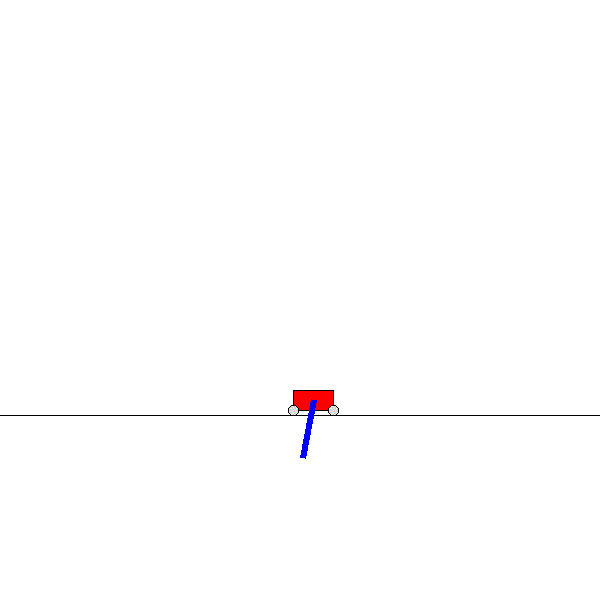

In [9]:
# Okay, let's test this simple cart-pole implementation.

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :]  # Expand dim, the leading is the batch dim.

# Initialize the task.
cart_pole_task = CartPole()
t_state = cart_pole_task.reset(reset_key)
task_screens = [CartPole.render(t_state, 0)]

# Rollout with random actions.
done = False
step_cnt = 0
total_reward = 0
while not done:
    action_key, rollout_key = jax.random.split(rollout_key, 2)
    action = jax.random.uniform(
        action_key, shape=(1, 1), minval=-1., maxval=1.)
    t_state, reward, done = cart_pole_task.step(t_state, action)
    total_reward = total_reward + reward
    step_cnt += 1
    if step_cnt % 4 == 0:
        task_screens.append(CartPole.render(t_state, 0))
print('reward={}, steps={}'.format(total_reward, step_cnt))

# Visualze the rollout.
gif_file = os.path.join(log_dir, 'rand_cartpole.gif')
task_screens[0].save(
    gif_file, save_all=True, append_images=task_screens[1:], loop=0)
Image(open(gif_file,'rb').read())

The random policy does not solve the cart-pole task, but our implementation seems to be correct. Let's now plug in this task to EvoJAX.

In [10]:
train_task = CartPole(test=False)
test_task = CartPole(test=True)

# We use the same policy and solver to solve this "new" task.
policy = MLPPolicy(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[64, 64],
    output_dim=train_task.act_shape[0],
    logger=logger,
)
solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)
trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=600,
    log_interval=100,
    test_interval=200,
    n_repeats=5,
    n_evaluations=128,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-02-12 05:58:16,702 [INFO] MLPPolicy.num_params = 4545
EvoJAX: 2022-02-12 05:58:16,868 [INFO] Start to train for 600 iterations.
EvoJAX: 2022-02-12 05:58:26,417 [INFO] Iter=100, size=64, max=704.6008, avg=538.1765, min=115.6323, std=110.1506
EvoJAX: 2022-02-12 05:58:34,678 [INFO] Iter=200, size=64, max=716.4336, avg=595.8668, min=381.3772, std=60.5778
EvoJAX: 2022-02-12 05:58:35,551 [INFO] [TEST] Iter=200, #tests=128, max=695.8007 avg=685.7385, min=668.2902, std=4.3287
EvoJAX: 2022-02-12 05:58:44,053 [INFO] Iter=300, size=64, max=759.5718, avg=658.8391, min=296.1095, std=71.2600
EvoJAX: 2022-02-12 05:58:52,540 [INFO] Iter=400, size=64, max=919.3878, avg=839.7709, min=134.9505, std=136.0545
EvoJAX: 2022-02-12 05:58:52,624 [INFO] [TEST] Iter=400, #tests=128, max=930.0361 avg=915.0107, min=900.9803, std=5.1936
EvoJAX: 2022-02-12 05:59:00,732 [INFO] Iter=500, size=64, max=926.3024, avg=812.4763, min=121.6825, std=229.5144
EvoJAX: 2022-02-12 05:59:09,005 [INFO] [TEST] Iter=600, 

reward=[923.1105]


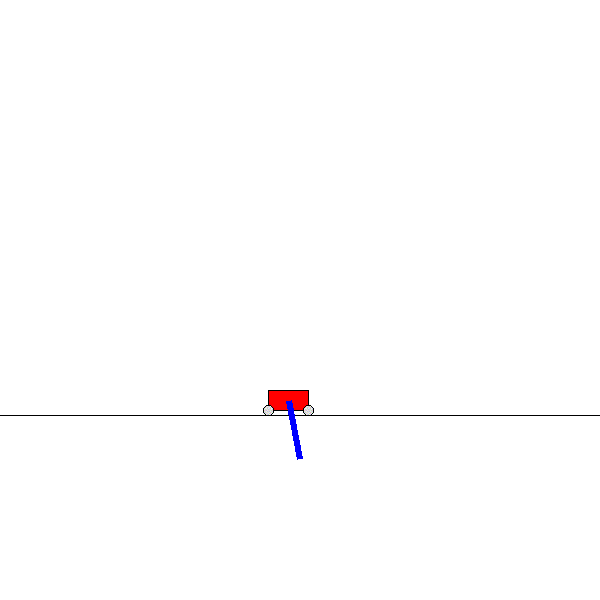

In [11]:
# Let's visualize the learned policy.

def render(task, algo, policy):
    """Render the learned policy."""

    task_reset_fn = jax.jit(test_task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(test_task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [CartPole.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, d = step_fn(task_s, act)
        step += 1
        reward = reward + r
        done = bool(d[0])
        if step % 3 == 0:
            images.append(CartPole.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


imgs = render(test_task, solver, policy)
gif_file = os.path.join(log_dir, 'trained_cartpole.gif')
imgs[0].save(
    gif_file, save_all=True, append_images=imgs[1:], duration=40, loop=0)
Image(open(gif_file,'rb').read())

Nice! EvoJAX is able to solve the new cart-pole task within a minute.

In this tutorial, we walked you through the process of creating tasks from scratch. The two examples we used are simple and are supposed to help you understand the interfaces. If you are interested in learning more, please check out our GitHub [repo](https://github.com/google/evojax/tree/main/evojax/task).

Please let us (evojax-dev@google.com) know if you have any problems or suggestions, thanks!